# Figure 6B. Plot rollout

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [3]:
from itertools import combinations
from typing import Any
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [4]:
from collab_env.gnn.gnn import plot_log_loss, train_rules_gnn, load_model, save_model, debug_result2prediction
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.sim.boids_gnn_temp.animal_simulation import visualize_graph_2sets, static_visualize_2sets

from collab_env.gnn.utility import dataset2testloader
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from itertools import product

In [5]:
smoke_test = "CI" in os.environ

save_flag = True if not smoke_test else False

In [49]:
data_names = ['boid_single_species_basic','boid_single_species_independent','boid_perturbed','boid_food_perturbed'] #'runpod/boid_single_species_basic']

data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'
data_names_short['boid_perturbed'] = 'boid_perturbed'
data_names_short['boid_food_perturbed'] = 'boid_food_perturbed'

### 1. Load rollout

### manual input parameter combinations, from model selection

In [23]:
all_combinations = [
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2),
    ('boid_single_species_independent', 'vpluspplus_a', 0.005, 1, 0.5, 3),
    ('boid_single_species_basic', 'vpluspplus_a', 0, 1, 0.5, 2),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2)
    # ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2),
    # ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4),
    # ('boid_food_strong', 'vpluspplus_a', 0.005, 3, 0.5, 0)
]

In [70]:
all_combinations = [
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2),
    ('boid_single_species_basic', 'GNNResidual', 0.005, 1, 0.5, 2),
    ('boid_single_species_basic', 'GNNResidual', 0.005, 1, 0.5, 0),
]

In [38]:
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2),
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4)
]

In [50]:
all_combinations = [
    ('boid_single_species_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2),
    ('boid_perturbed', 'vpluspplus_a', 0.005, 3, 0.5, 2)]
#'boidperturbed_\nn0.005_h3_vr0.5_s2_vpluspplus_a'

In [63]:
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2),
    ('boid_food_perturbed', 'vpluspplus_a', 0.005, 3, 0.5, 0)]
#'boidperturbed_\nn0.005_h3_vr0.5_s2_vpluspplus_a'

In [71]:
rollout_results =  {}
data = {}
model_names = {}
ablation = False
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = True
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation
    }
    
    data_name_short = data_names_short[data_name]
    model_save_name = f'{model_name}_{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            model_name, **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  False
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2_rollout5.pkl
0, Successfully import vpluspplus_a_boid_
n0.005_h1_vr0.5_s2
ablation  False
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_GNNResidual_n0.005_h1_vr0.5_s2_rollout5.pkl
1, Successfully import GNNResidual_boid_
n0.005_h1_vr0.5_s2
ablation  False
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_GNNResidual_n0.005_h1_vr0.5_s0_rollout5.pkl
2, Successfully import GNNResidual_boid_
n0.005_h1_vr0.5_s0


In [72]:
datasets = load_various_data(data_names, 1, return_dict = True)

### Rollout parameters

In [73]:
save_flag = 0

In [77]:
rollout_num = 30
file_id = 9 #13, 9, 10, 13, 260, 278, 263
starting_frame = 0
rollout_starting_frame = 5 - 3 #rollout result start to tally at frame 3
ending_frame = rollout_starting_frame + rollout_num

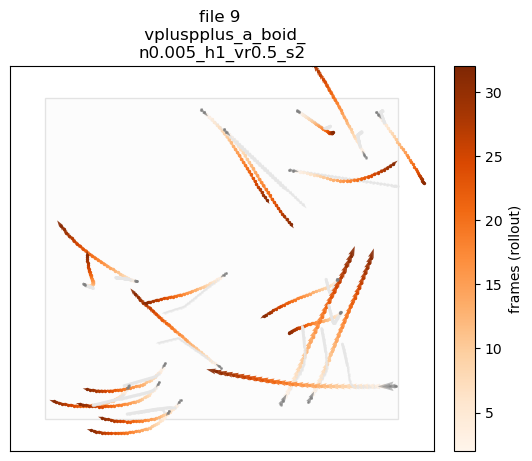

In [78]:
%matplotlib inline

model = 0
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                ending_frame = ending_frame)

ax.set_title(f'file {file_id} \n {model_names[model]}')
if save_flag:
    plt.savefig(f"rollout_file{file_id}_{model_names[model]}_{rollout_num}.pdf", bbox_inches="tight")
plt.show()

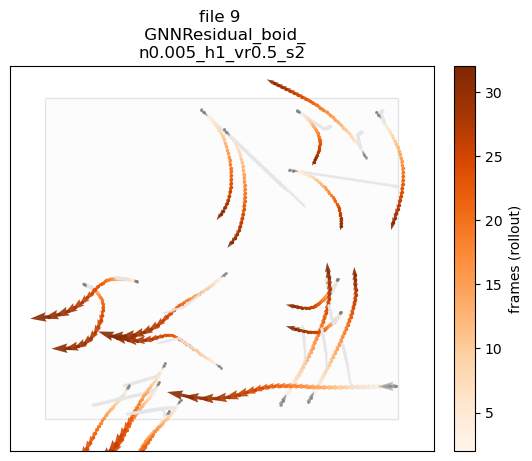

In [79]:
model = 1

actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                            ending_frame = ending_frame)
ax.set_title(f'file {file_id} \n {model_names[model]}')
if save_flag:
    plt.savefig(f"rollout_file{file_id}_{model_names[model]}_ablate_{rollout_num}.pdf", bbox_inches="tight")
plt.show()
    

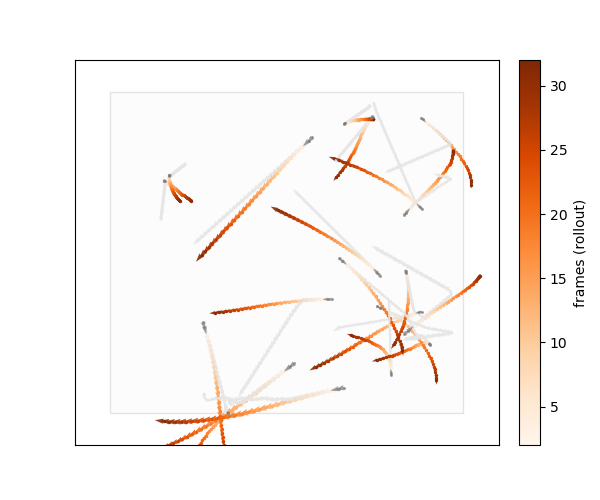

In [26]:
model = 1

actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[model],
                    file_id = file_id, epoch_num = 0)


ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                            ending_frame = ending_frame)
if save_flag:
    plt.savefig(f"rollout_file{file_id}_{model_names[model]}_ablate_{rollout_num}.pdf", bbox_inches="tight")

### 2. Make gif

p0 shape torch.Size([21, 2])
p shape torch.Size([197, 21, 2])


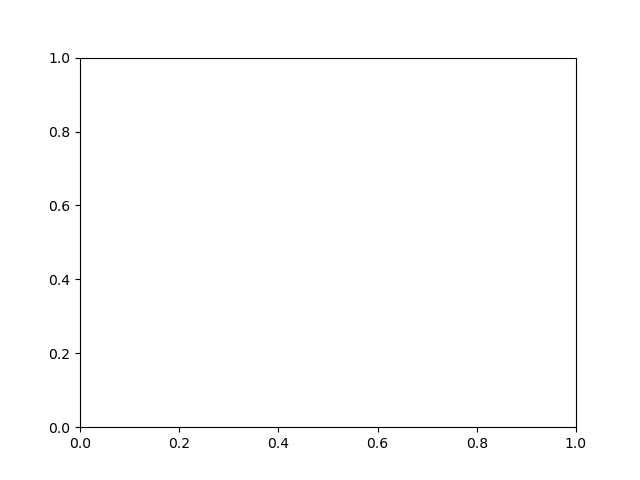

MovieWriter imagemagick unavailable; using Pillow instead.


In [45]:
%matplotlib widget

ani, ax = visualize_graph_2sets(actual_pos[0], actual_vel[0] * 10, gnn_pos[0], gnn_vel[0] * 10,
                      starting_frame = 0,
                      ending_frame = 95, title = "Boid foraging", food_source = [1/3, 0])
#plot_weighted_graph(pos_dict, Win_f, ax, [node])
folder = "/workspace/collab-environment/figures/gnn/"

save_name = f"{folder}food_boid_rollout_example_file{file_id}.gif"
ani.save(save_name, writer='imagemagick', fps=30)